> üöÄ This notebook explores personality classification using behavioral traits and machine learning models. The goal is to predict whether someone is an *Introvert* or *Extrovert* based on their habits and preferences.

# Personality Classification Project: Introvert vs Extrovert

This project uses a dataset that contains behavioral traits to classify individuals as either Introverts or Extroverts. Features include time spent alone, stage fear, social activity, and more.

## Step 1: Data Overview

We begin by loading and examining the structure of the dataset using basic pandas methods like `info()`, `shape`, and `describe()`.

These help us understand:

- Column types  
- Missing values  
- Data distributions  
- Overall shape of the dataset

In [1]:
# Import Libraries
# This section contains all required libraries grouped by functionality for clarity.

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

# Model Building
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Clean Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Loading the Dataset
df = pd.read_excel("personality_dataset.xlsx", sheet_name='personality_dataset')

In [3]:
df.shape

(2900, 8)

In [4]:
#First Few Rows
df.head()

Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert

In [5]:
#Basic Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [6]:
#Descriptive Statistics
df.describe()

Time_spent_Alone  Social_event_attendance  Going_outside  \
count       2837.000000              2838.000000    2834.000000   
mean           4.505816                 3.963354       3.000000   
std            3.479192                 2.903827       2.247327   
min            0.000000                 0.000000       0.000000   
25%            2.000000                 2.000000       1.000000   
50%            4.000000                 3.000000       3.000000   
75%            8.000000                 6.000000       5.000000   
max           11.000000                10.000000       7.000000   

       Friends_circle_size  Post_frequency  
count          2823.000000     2835.000000  
mean              6.268863        3.564727  
std               4.289693        2.926582  
min               0.000000        0.000000  
25%               3.000000        1.000000  
50%               5.000000        3.000000  
75%              10.000000        6.000000  
max              15.000000       10.000000

## Step 2: Exploratory Data Analysis (Pre-Cleaning)

Before performing any data cleaning or encoding, we explore the raw data to understand how different traits vary across the two personality types.

- **Step 1**: We check the distribution of personality types to ensure the dataset is balanced.
- **Step 2**: We generate countplots and histograms for each feature, comparing how introverts and extroverts differ on traits like stage fear, time spent alone, and post frequency.

This helps us identify:
- Which features are more strongly associated with one personality type
- Possible data imbalances
- Weird or inconsistent values that need cleaning

In [7]:
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

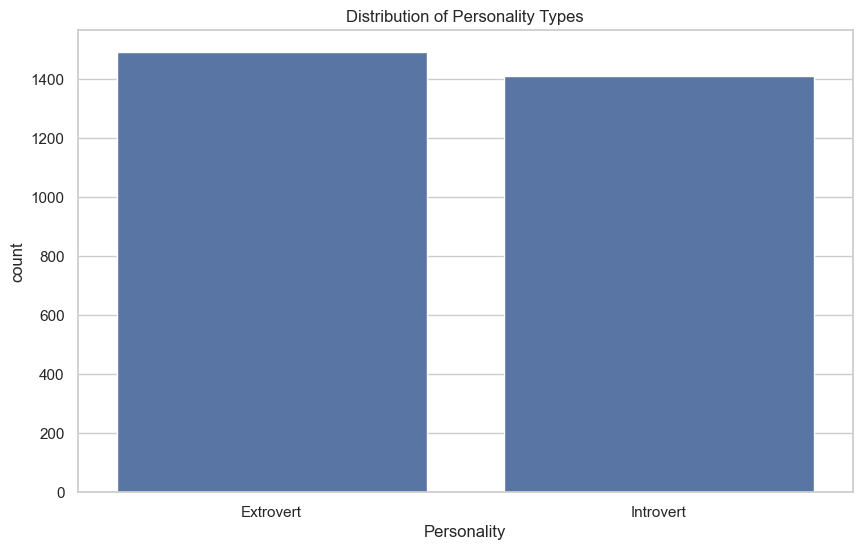

In [8]:
#Distribution of Personality Types

sns.countplot(data=df, x='Personality')
plt.title("Distribution of Personality Types")
plt.show()

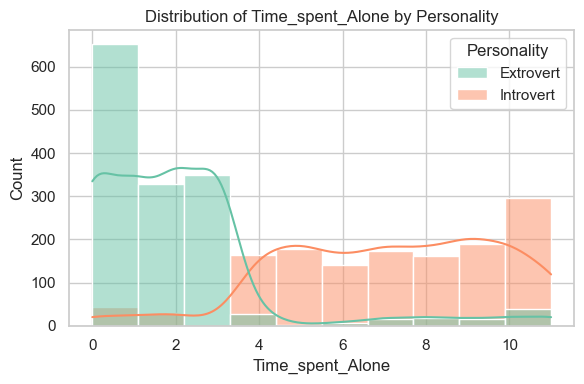

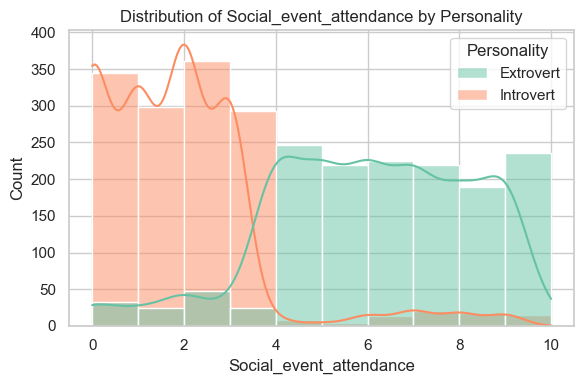

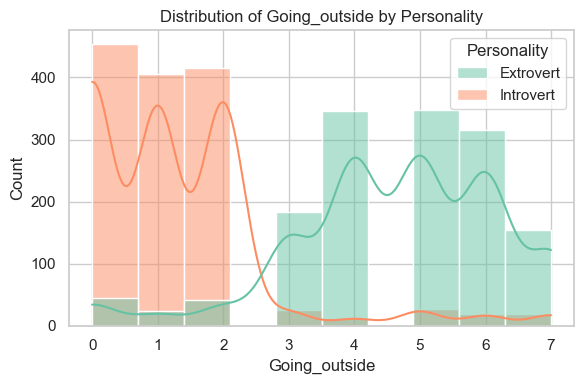

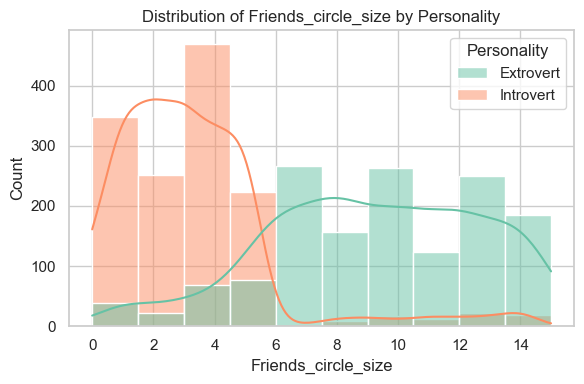

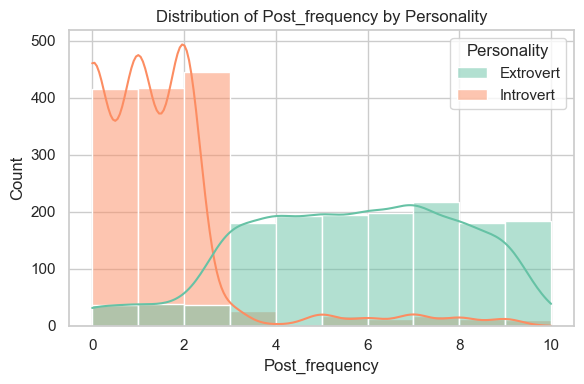

In [9]:
# Histograms

for col in df.columns:
    if col != 'Personality' and df[col].nunique() > 2:
        plt.figure(figsize=(6,4))
        sns.histplot(data=df, x=col, hue='Personality', bins=10, kde=True, palette='Set2')
        plt.title(f'Distribution of {col} by Personality')
        plt.tight_layout()
        plt.show()

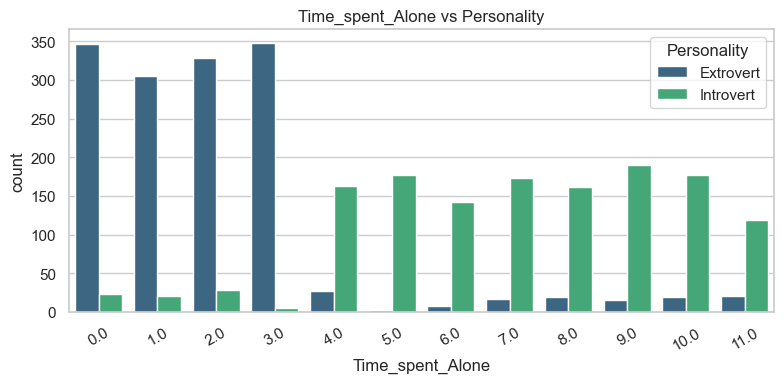

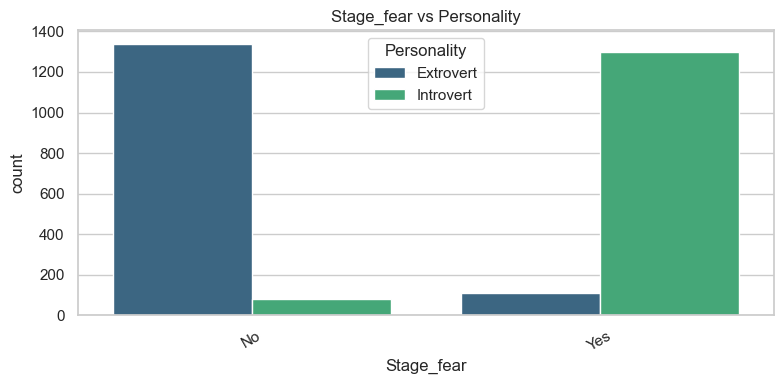

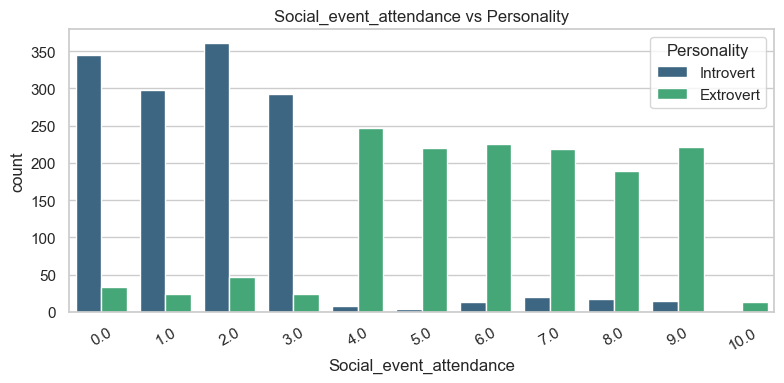

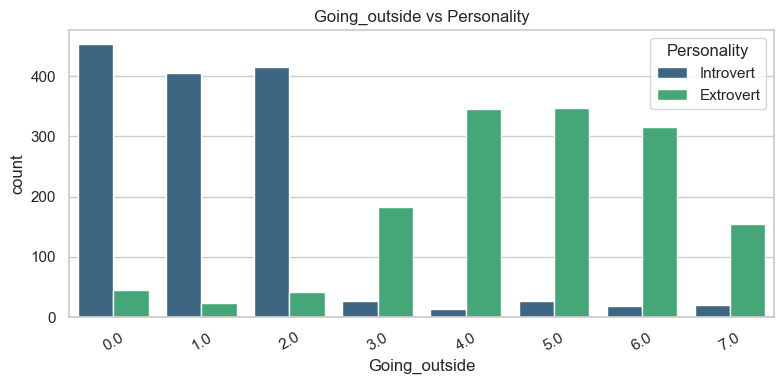

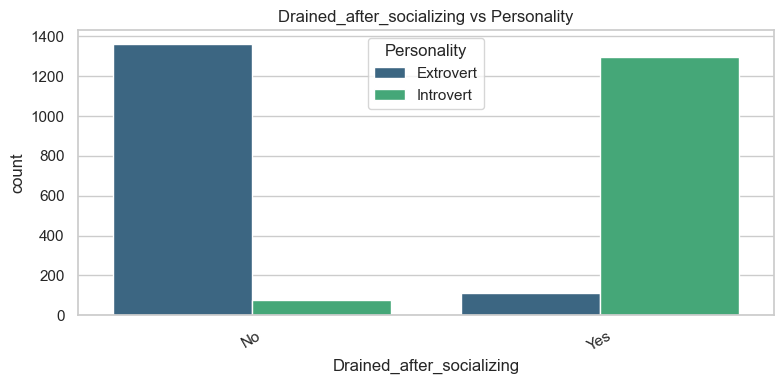

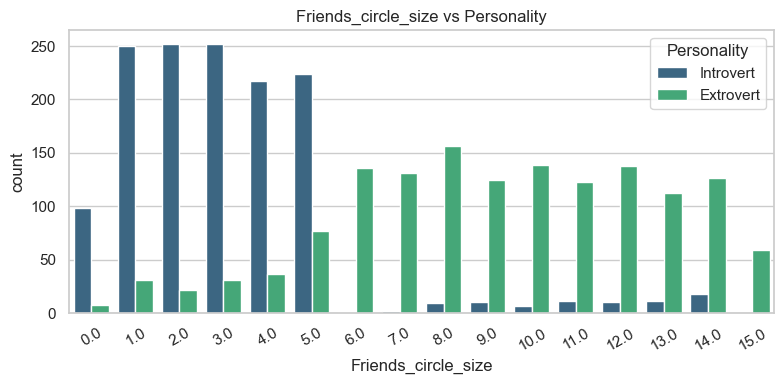

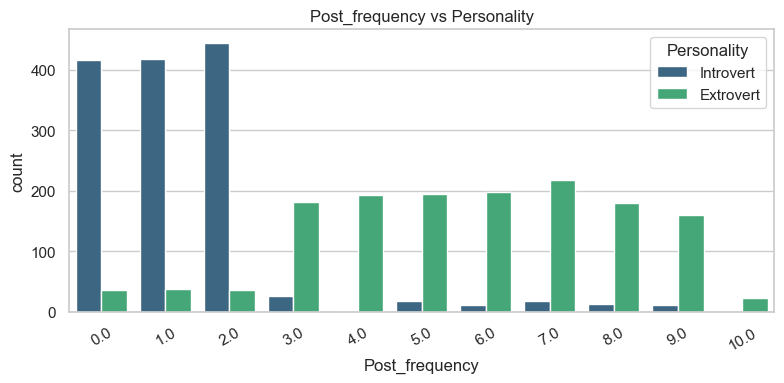

In [10]:
# CountPlots: Compare each trait by personality

columns = df.columns.drop('Personality')

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='Personality', palette='viridis')
    plt.title(f'{col} vs Personality')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

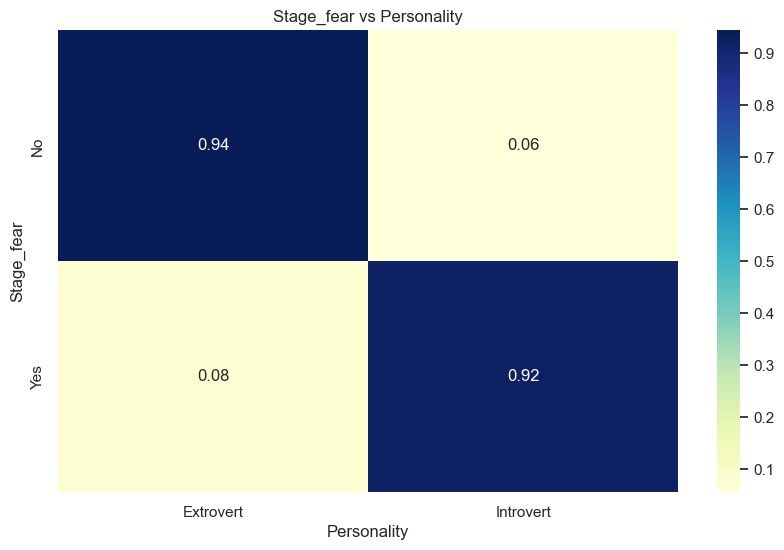

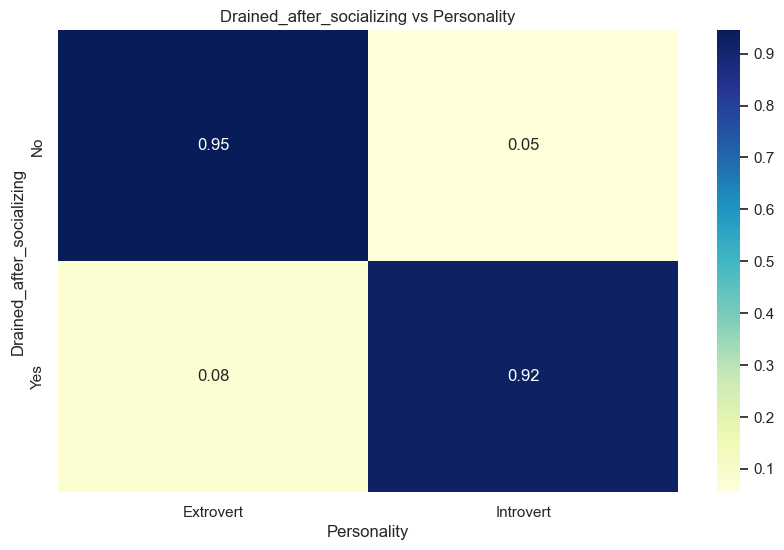

In [11]:
#Crosstab

for col in df.columns:
    if col != "Personality" and df[col].nunique() <= 5:
        ct = pd.crosstab(df[col], df["Personality"], normalize='index')
        sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title(f"{col} vs Personality")
        plt.ylabel(col)
        plt.xlabel("Personality")
        plt.show()

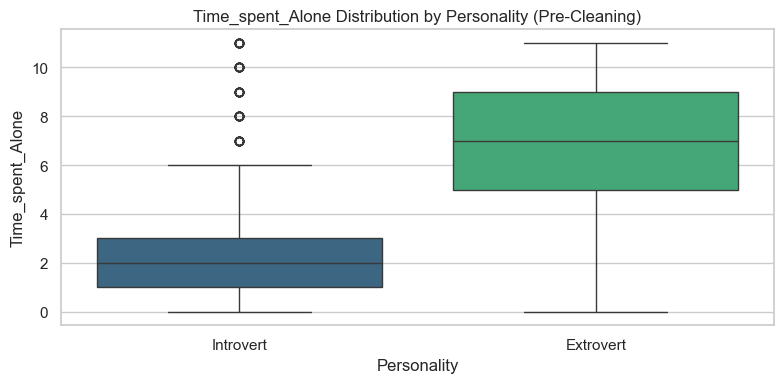

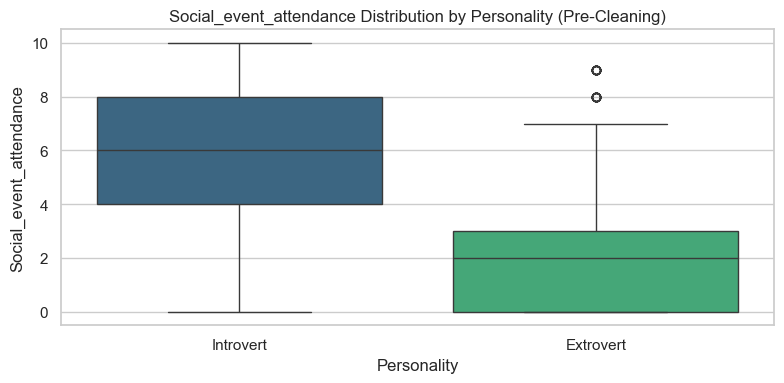

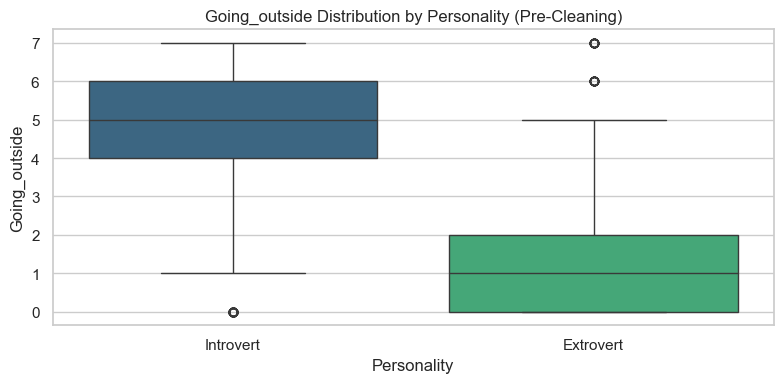

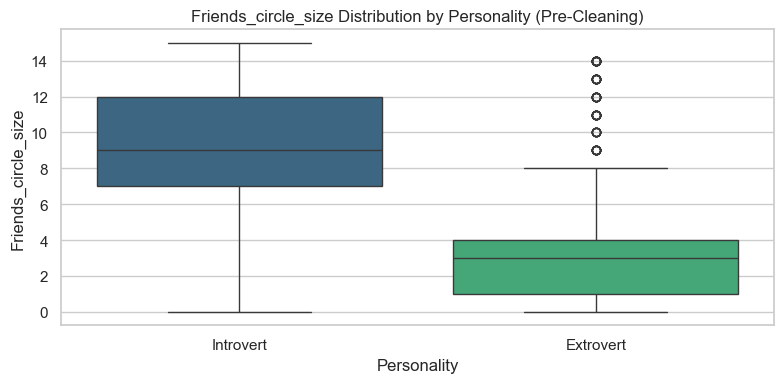

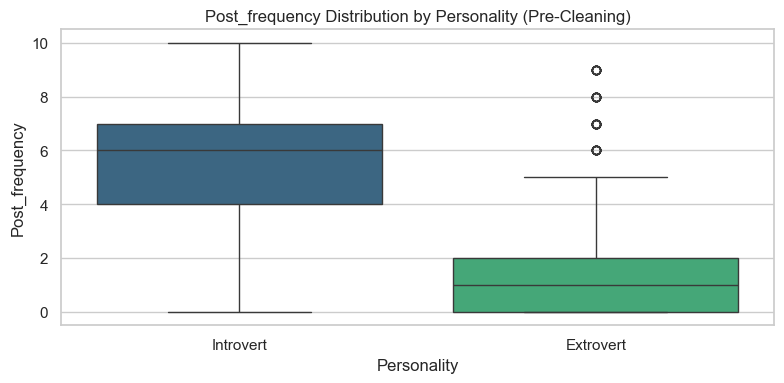

In [12]:
# Boxplots for numeric features
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='Personality', y=col, palette='viridis')
    plt.title(f'{col} Distribution by Personality (Pre-Cleaning)')
    plt.xticks([0, 1], ['Introvert', 'Extrovert'])
    plt.tight_layout()
    plt.show()

### Summary

#### Personality Type Distribution
- The dataset is well-balanced between **Extroverts (~1450)** and **Introverts (~1400)**.
- This balance minimizes the risk of model bias during classification.

#### Key Takeaways
- Clear behavioral patterns distinguish Extroverts from Introverts in several features.
- Some **binary features (e.g., Stage Fear)** are heavily imbalanced and may require special handling during preprocessing.
- **Outliers** exist in all the features, suggesting a need for outlier treatment during data cleaning.

> Note: Correlation heatmap is intentionally skipped at this stage as binary and categorical variables are yet to be encoded. It will be revisited post-preprocessing for more reliable insights.


## Step 3: Data Cleaning: Handling Missing Values

All the features in this dataset (excluding the target) are either binary or numeric. Based on this, we applied the following cleaning steps:

- **Binary features** (`Stage_fear`, `Drained_after_socializing`) were imputed using the **mode** to preserve the natural class distribution.
- **Numeric features** (`Time_spent_Alone`, `Social_event_attendance`, `Going_outside`, `Friends_circle_size`, `Post_frequency`) were filled with the **median**, which helps reduce the influence of outliers and skewed data.
- Any rows missing the **target variable** (`Personality`) were dropped, since we can‚Äôt use them for supervised learning anyway.


In [13]:
print(df.isnull().sum())

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64


In [14]:
# Filling binary columns with mode

binary_cols = ['Stage_fear', 'Drained_after_socializing']
for col in binary_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [15]:
# Filling numerical (ordinal/discrete) columns with median

num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

> *Note: Redundant operations like `dropna(subset=['Personality'])` were avoided to keep the process clean and efficient as the Personality column contains 0 null values*

In [16]:
print(df.isnull().sum())

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


### Encoding Categorical Variables

Before training our models, all categorical features must be converted into numerical format.  
We used **Label Encoding** for binary categorical variables and **One-Hot Encoding** for nominal multi-class features.

- **Label Encoding** is applied where the categories have only two values (e.g., Yes/No, Male/Female).
- **One-Hot Encoding** is used for variables with more than two distinct categories, avoiding any unintended ordinal relationships.

This ensures compatibility with machine learning algorithms and prevents misinterpretation of categorical data.

In [17]:
# Binary encoding map
binary_map = {'Yes': 1, 'No': 0}
target_map = {'Introvert': 0, 'Extrovert': 1}

# Encode binary columns
df['Stage_fear'] = df['Stage_fear'].map(binary_map)
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(binary_map)

# Encode target variable
df['Personality'] = df['Personality'].map(target_map)

In [18]:
df.head()

Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0            2.0   
3               0.0           0                      6.0            7.0   
4               3.0           0                      9.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                          0                 13.0             5.0            1  
1                          1                  0.0             3.0            0  
2                          1                  5.0             2.0            0  
3                          0                 14.0             8.0            1  
4                          0                  8.0             5.0            1

## Step 4: Exploratory Data Analysis (Post-Cleaning)

With a clean dataset in hand, we now explore patterns and relationships between traits and personality types:

- **Trait Distributions by Personality**: Histograms and boxplots help us visualize how each behavioral trait is spread across introverts and extroverts.
- **Feature Correlation**: A heatmap reveals which traits are related and may influence one another.
- **Cross-tab Analysis**: Binary traits like `Stage_fear` and `Drained_after_socializing` are examined for their alignment with personality types.
- **Group-level Insights**: Aggregated means across traits give a quick comparison between introverts and extroverts.


In [19]:
#Comparing means

df.groupby('Personality').mean(numeric_only=True).T

Personality                       0         1
Time_spent_Alone           7.017033  2.111335
Stage_fear                 0.921930  0.074447
Social_event_attendance    1.808375  5.959759
Going_outside              1.310859  4.596244
Drained_after_socializing  0.919801  0.074447
Friends_circle_size        3.244145  9.061704
Post_frequency             1.405962  5.580148

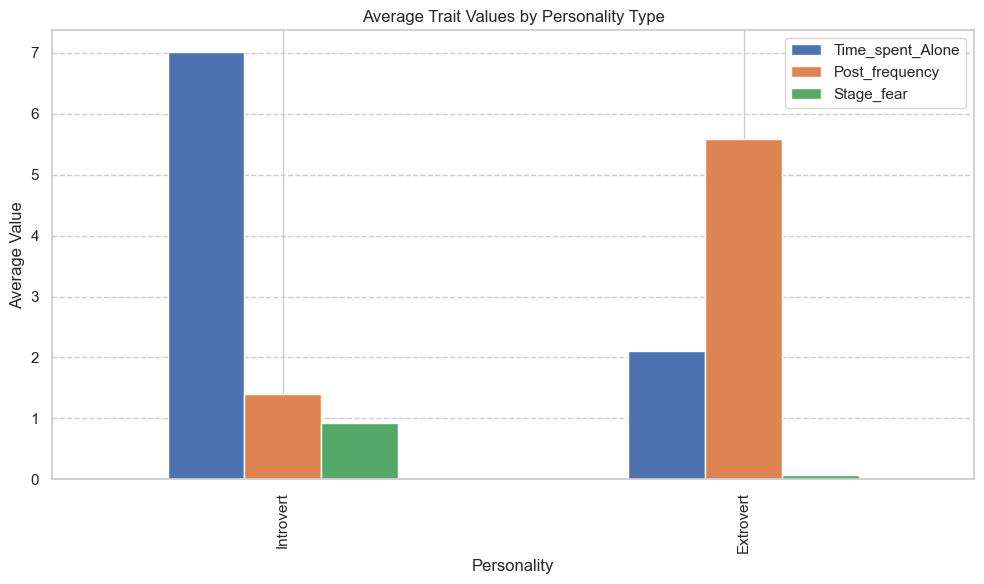

In [20]:
# Group means plot

group_means = df.groupby('Personality')[['Time_spent_Alone', 'Post_frequency', 'Stage_fear']].mean()

# Plot
group_means.plot(kind='bar', figsize=(10,6))
plt.title("Average Trait Values by Personality Type")
plt.ylabel("Average Value")
plt.xticks([0, 1], ['Introvert', 'Extrovert'])
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

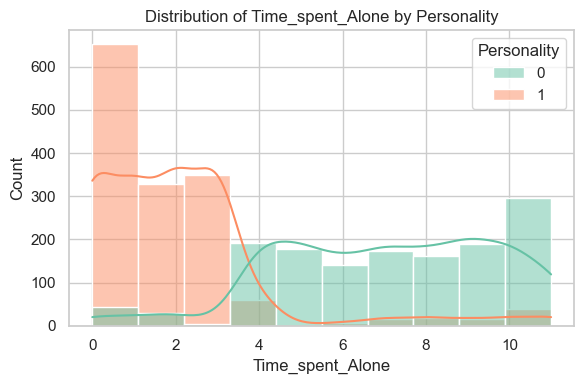

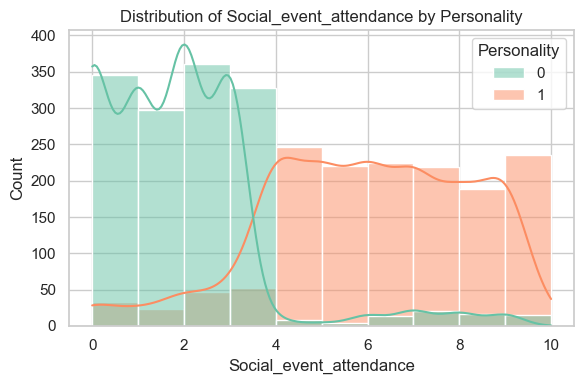

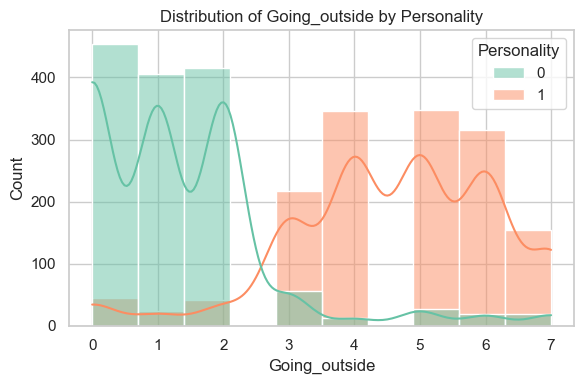

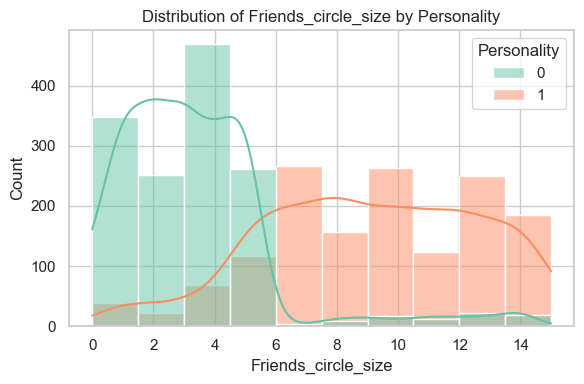

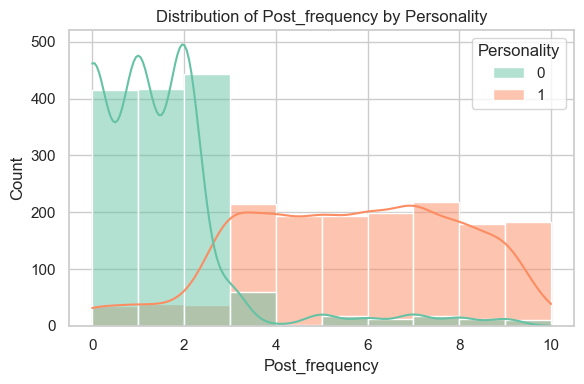

In [21]:
# Histograms

for col in df.columns:
    if col != 'Personality' and df[col].nunique() > 2:
        plt.figure(figsize=(6,4))
        sns.histplot(data=df, x=col, hue='Personality', bins=10, kde=True, palette='Set2')
        plt.title(f'Distribution of {col} by Personality')
        plt.tight_layout()
        plt.show()

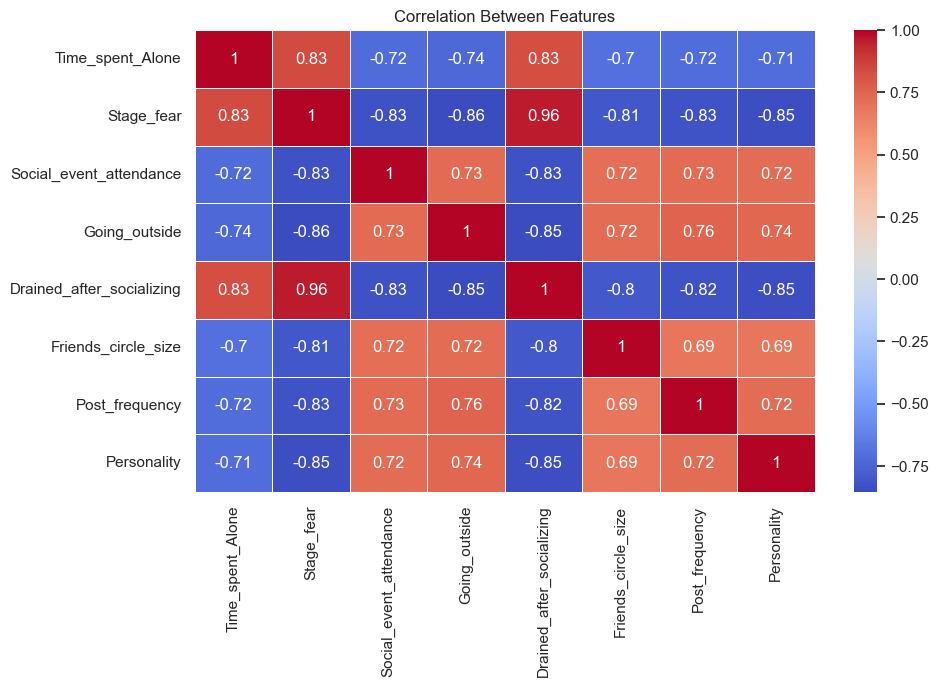

In [22]:
#Heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Features")
plt.show()

In [49]:
print(df[['Time_spent_Alone', 'Stage_fear', 'Personality']].corr())

                  Time_spent_Alone  Stage_fear  Personality
Time_spent_Alone          1.000000    0.834645    -0.712467
Stage_fear                0.834645    1.000000    -0.847467
Personality              -0.712467   -0.847467     1.000000


> Though the correlation between the `Stage_fear`, and `Time_spent_Alone` have high correlation they are very important for the personality prediction as shown above.
Hence, we don't need to drop one of either.

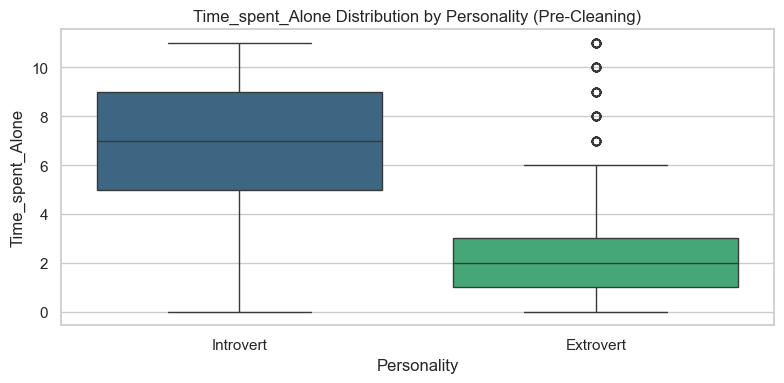

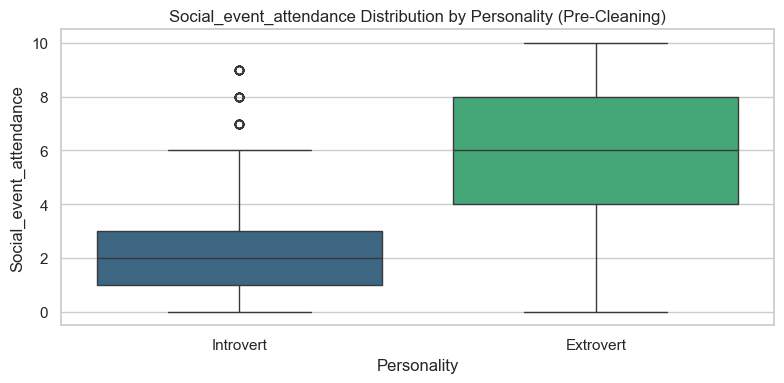

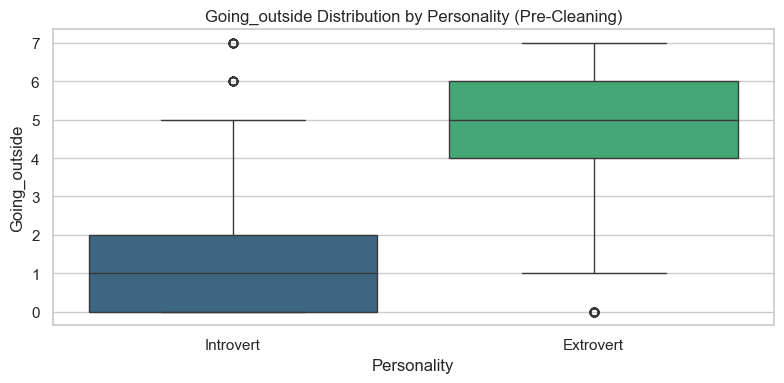

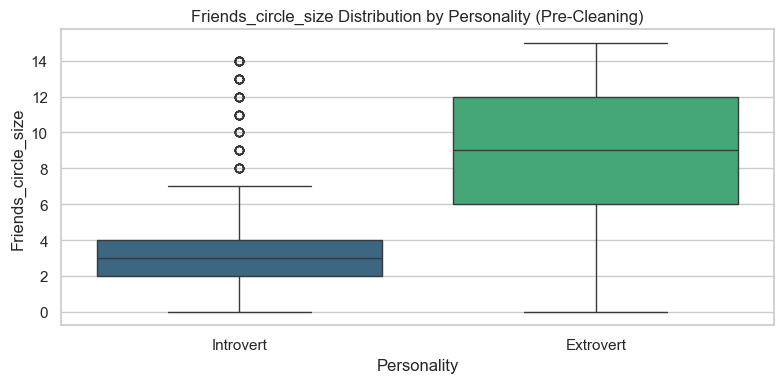

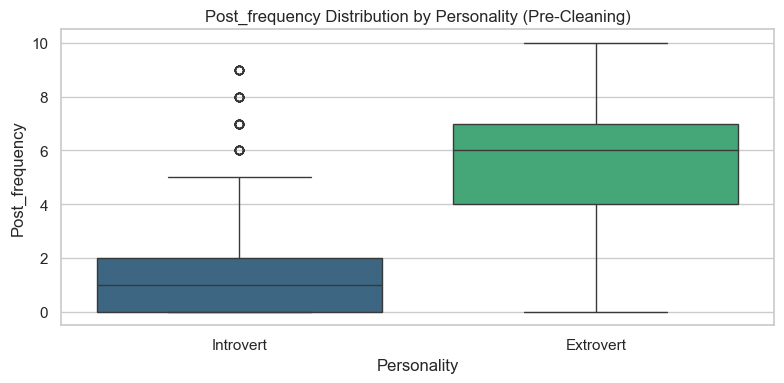

In [23]:
# Boxplots for numeric features
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='Personality', y=col, palette='viridis')
    plt.title(f'{col} Distribution by Personality (Post-Cleaning)')
    plt.xticks([0, 1], ['Introvert', 'Extrovert'])
    plt.tight_layout()
    plt.show()

> While **boxplots** show general trends between extroverts and introverts, there are notable outliers.
Some extroverts spend significant time alone, and some introverts frequently attend social events.
This highlights the individual ambiguity in personality traits ‚Äî suggesting that introversion and extroversion cannot be defined by a single behavior alone.
Instead, personality is shaped by a combination of traits, and the data reflects this nuanced spectrum.

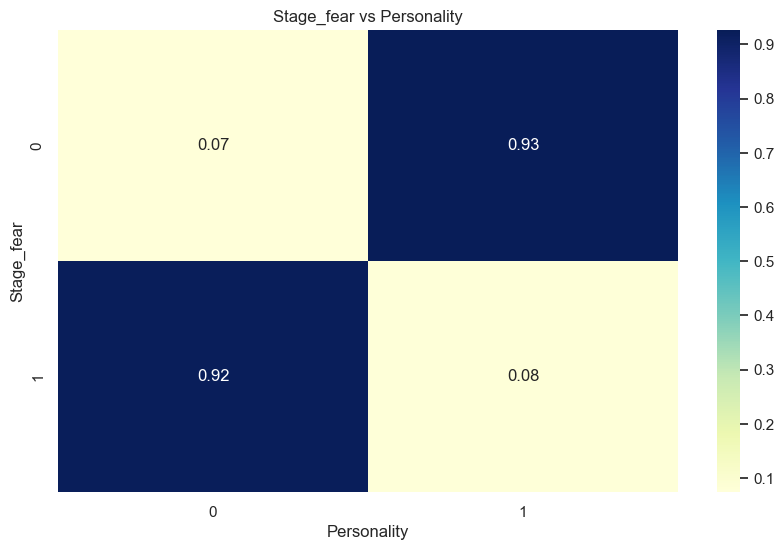

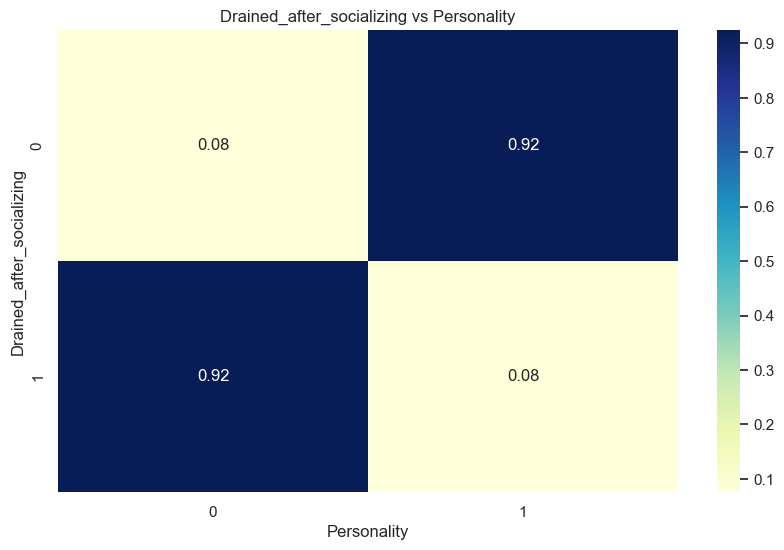

In [24]:
#Behavioral Cross-Tab Heatmaps

for col in ['Stage_fear', 'Drained_after_socializing']:
    ct = pd.crosstab(df[col], df['Personality'], normalize='index')
    sns.heatmap(ct, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(f'{col} vs Personality')
    plt.show()

## Model Building and Evaluation

We train multiple classification models on the dataset to predict personality types. These include:

- Logistic Regression
- Decision Tree
- Random Forest
- K-Nearest Neighbors
- Support Vector Machine
- XGBoost

After training, we evaluate each model using accuracy and select the best performer for further analysis.


In [25]:
#Splitting the data
from sklearn.model_selection import train_test_split

X = df.drop("Personality", axis=1)
y = df["Personality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

Trained a Logistic Regression model to classify personality as Introvert or Extrovert based on social behavior traits.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Train Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

#Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       282
           1       0.93      0.91      0.92       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



## Decision Tree Classifier

Used a Decision Tree model to classify individuals as Introvert or Extrovert based on social behavior patterns.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize and train the model
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Predict and evaluate
y_pred = dtree.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       282
           1       0.91      0.88      0.89       298

    accuracy                           0.89       580
   macro avg       0.89      0.89      0.89       580
weighted avg       0.89      0.89      0.89       580



## Random Forest Classifier

Used Random Forest to classify personality traits by aggregating predictions from multiple decision trees.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       282
           1       0.92      0.90      0.91       298

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580



## K-Nearest Neighbors

Used KNN to classify individuals as Introvert or Extrovert based on proximity to similar social behavior patterns.

In [29]:
#Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Initialize and train the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test_scaled)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       282
           1       0.94      0.90      0.92       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



## Support Vector Machine (SVM)

Used SVM to classify personality traits by maximizing the margin between introverts and extroverts in the feature space.

In [31]:
#Scaling

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize and train the model
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test_scaled)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(svm, X, y, cv=5, scoring='f1')
print("Cross-validated F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean())

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       282
           1       0.94      0.91      0.93       298

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Cross-validated F1 scores: [0.97306397 0.93898305 0.93015332 0.91595197 0.91946309]
Mean F1: 0.9355230811383297


## XGBoost Classifier

Used XGBoost to classify introvert vs. extrovert personalities by combining multiple boosted trees for enhanced accuracy.

In [41]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Initialize and train the model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       282
           1       0.92      0.90      0.91       298

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580



## Comparing the Results

Gathering all the metrics from above models and visualizing it with simple bar plot.

In [43]:
#Wrapping All Models

# Model dictionary
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(), 
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss') }

#Looping through and collecting metrics

results = []

for name, model in models.items():
    # For KNN and SVM, use scaled data
    if name in ["KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    })


In [45]:
#Display

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="F1 Score", ascending=False)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1 Score
4                  SVM  0.924138   0.937931  0.912752  0.925170
0  Logistic Regression  0.918966   0.928328  0.912752  0.920474
3                  KNN  0.918966   0.937282  0.902685  0.919658
5              XGBoost  0.908621   0.920962  0.899329  0.910017
2        Random Forest  0.906897   0.914966  0.902685  0.908784
1        Decision Tree  0.893103   0.906897  0.882550  0.894558


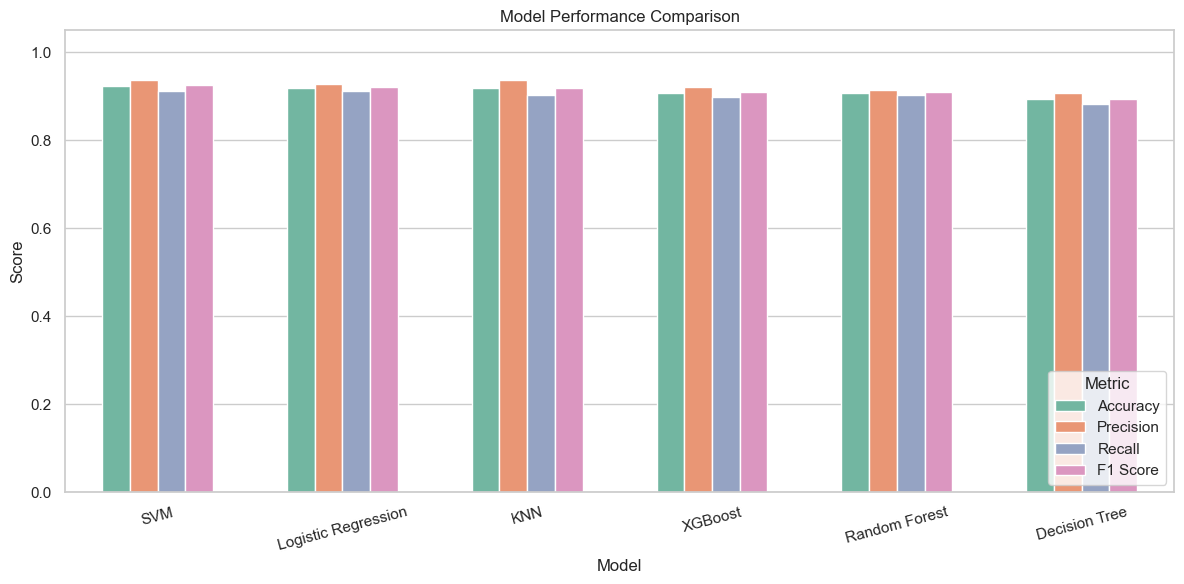

In [51]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric", palette="Set2", width = 0.6)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.ylim(0, 1.05)
plt.legend(title="Metric", loc="lower right")
plt.tight_layout()
plt.show()

> Among all the models tested, **Support Vector Machine (SVM)** delivered the strongest overall performance.
While **KNN** and **Logistic Regression** came close in terms of accuracy, they fell short on precision and recall, especially in correctly identifying both personality classes.
As a result, SVM emerged as the most balanced and reliable classifier in this analysis.

## Conclusion

This project successfully explores how behavioral traits can be used to classify individuals as Introverts or Extroverts using various machine learning models . The dataset includes features like time spent alone, stage fear, social event attendance, and more ‚Äî all of which show meaningful differences between personality types.

### Key Takeaways:
- **Distinct Behavioral Patterns** :
Extroverts tend to spend less time alone, attend more events, go outside more often, have larger friend circles, and post more frequently than Introverts.
- **Feature Correlation** :
Features like Time_spent_Alone and Stage_fear are strongly correlated with being an Introvert, while Social_event_attendance and Post_frequency are strong indicators of being an Extrovert.
- **Model Performance** :
Multiple classification models were trained, including Logistic Regression, Decision Tree, Random Forest, KNN, SVM, and XGBoost. The top performers (SVM, Logistic Regression, and KNN) achieved an F1-score of 0.92 , showing high predictive power from the input features.
- **Real-World Complexity** :
Boxplots and histograms also revealed individual variability ‚Äî not every person fits perfectly into one category. This ambiguity makes personality prediction both challenging and realistic.